# Training a Pytorch NN on the Intel Image Dataset

***Loading the data***

In [5]:
import cv2
import os

IMGSIZE = (128, 128)
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
_path = '/home/yahya/Downloads/archive (4)'
_labels = CNAMES

X_tr, y_tr, X_ts, y_ts = [], [], [], []
for label in _labels:
    path = _path + '/seg_train/seg_train/' + label
    for f in sorted([_ for _ in os.listdir(path) if
        _.lower().endswith('.jpg')]):
        X_tr += [cv2.resize(cv2.imread(os.path.join(path,f)), IMGSIZE)]
        y_tr += [CNAMES.index(label)]

In [6]:
len(X_tr[1])

128

In [7]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [8]:
len(y_tr)

14034

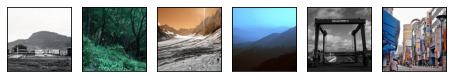

In [9]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(nrows=1, ncols=6, sharex='all', sharey='all', dpi=72)
ax = ax.flatten()
img_i=0
count=0
while img_i<=10 and count<len(y_tr):
    if y_tr[count]==img_i:
        img = X_tr[count]
        ax[img_i].imshow(img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        plt.tight_layout()
        img_i+=1
    count+=1
plt.show()

Buildings, Forests, glacier, mountain, sea, street.

***2. Normalizing the pixel RGB values***

In [10]:
import numpy as np

X_tr = np.array(X_tr)
y_tr = np.array(y_tr)
X_ts = np.array(X_ts)
y_ts = np.array(y_ts)

In [11]:
print(type(X_tr), type(X_tr[0]), type(X_tr[0][0]), type(X_tr[0][0][0]))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [12]:
print(len(X_tr), len(X_tr[0]), len(X_tr[0][0]), len(X_tr[0][0][0]))

14034 128 128 3


In [13]:
# example of pixel normalization
from numpy import asarray
from PIL import Image
# load image
# confirm pixel range is 0-255
print('Data Type: %s' % X_tr.dtype)
print('Min: %.3f, Max: %.3f' % (X_tr.min(), X_tr.max()))
# convert from integers to floats
X_tr_norm = X_tr.astype('float32')
# normalize to the range 0-1
X_tr_norm /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (X_tr_norm.min(), X_tr_norm.max()))

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000


In [14]:
X_tr_norm[0][0][0:10]

array([[0.9607843 , 0.96862745, 0.96862745],
       [0.9607843 , 0.96862745, 0.96862745],
       [0.9647059 , 0.972549  , 0.972549  ],
       [0.9647059 , 0.972549  , 0.972549  ],
       [0.96862745, 0.98039216, 0.972549  ],
       [0.96862745, 0.98039216, 0.972549  ],
       [0.96862745, 0.98039216, 0.972549  ],
       [0.9647059 , 0.9764706 , 0.96862745],
       [0.96862745, 0.98039216, 0.972549  ],
       [0.972549  , 0.9882353 , 0.96862745]], dtype=float32)

***Splitting training, testing, and validation data***

In [15]:
from sklearn.model_selection import train_test_split

# Use validation to measure generalization performance
X_train, X_test, y_train, y_test = train_test_split(X_tr_norm, y_tr, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [16]:
import torch

X_train = torch.tensor(X_train)
X_train = torch.flatten(X_train, start_dim=1)

In [17]:
X_test = torch.tensor(X_test)
X_test = torch.flatten(X_test, start_dim=1)

y_test = torch.tensor(y_test)

In [18]:
X_val = torch.tensor(X_val)
X_val = torch.flatten(X_val, start_dim=1)

y_val = torch.tensor(y_val)

In [19]:
y_train = torch.tensor(y_train)

In [20]:
print(X_train.dtype, X_test.dtype, X_val.dtype)

torch.float32 torch.float32 torch.float32


***Neural Network Architecture***

In [95]:
import torch.nn as nn

class MyNetwork(nn.Module):
    """ A PyTorch neural network model """
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(49152, 50)  # A simple input layer, size M x Hsize
        self.fc2 = nn.Linear( 50, 50)  # A simple hidden layer, size Hsize x Hsize
        self.fc3 = nn.Linear( 50,  6)  # A simple output layer, size Hsize x K

    def forward(self, _x, apply_softmax=False):
        _x = nn.functional.relu(self.fc1(_x))
        _x = nn.functional.relu(self.fc2(_x))
        _x = self.fc3(_x)
        if apply_softmax:
            _x = nn.functional.softmax(_x, dim=1)
        return _x

In [96]:
# Instantiate the neural network
Net1 = MyNetwork()
print(Net1)

# Set the learning rate - this part is magic of course
eta = 0.005

MyNetwork(
  (fc1): Linear(in_features=49152, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)


In [97]:
import torch.optim as optim

# Create a Stochastic Gradient Descent optimizer
optimizer = optim.SGD(Net1.parameters(), lr=eta, momentum=0.9)

# Create the loss function
loss_func = nn.CrossEntropyLoss()

In [98]:
def predict(_x):
    net_out = Net1.forward(_x, apply_softmax=True)
    p_values, indices = net_out.max(dim=1)
    return indices

In [99]:
%%time
import sys

epochs=100
minibatch_size=512

# The main training loop
for i in range(epochs):
    indices = np.arange(X_train.shape[0])
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        # step 1.
        optimizer.zero_grad()
        # step 2.
        net_out = Net1.forward(X_train[batch_idx])
        # step 3.
        loss = loss_func(net_out, y_train[batch_idx])
        # step 4.
        loss.backward()
        # step 5.
        optimizer.step()

    y_pred = predict(X_train)
    y_val_pred = predict(X_val)
    
    train_acc = (torch.sum(y_train == y_pred).float() / X_train.shape[0])
    val_acc = (torch.sum(y_val == y_val_pred).float() / X_val.shape[0])
    
    sys.stderr.write(f"\r{i+1}/{epochs} | Cost: {loss:.2f} | Train/Valid Acc.: {train_acc*100:.2f}%/{val_acc*100:.2f}%")
    sys.stderr.flush()

100/100 | Cost: 0.61 | Train/Valid Acc.: 74.46%/57.68%

CPU times: user 6min 16s, sys: 42.7 s, total: 6min 59s
Wall time: 2min 33s


In [100]:
len(y_tr)

14034

In [101]:
y_pred = predict(X_test)
test_acc = (torch.sum(y_test == y_pred).float() / X_test.shape[0])

print(f"Feedforward NN testing accuracy= {test_acc:.2f}")

Feedforward NN testing accuracy= 0.56


We can ofcourse improve this by using more neurons per layer. Something close to the square root of the input layer neuron size times the output layer neuron size would be most effective. sqrt(49152*6) = 543.

Also decrememnting the neurons in each layer to reach the output layer size and applying 3 layers. 

**Improvements to NN Architecture**

In [90]:
import torch.nn as nn

class MyNetwork(nn.Module):
    """ A PyTorch neural network model """
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(49152, 512)  # A simple input layer, size M x Hsize
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear( 512, 256)  # A simple hidden layer, size Hsize x Hsize
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear( 256, 128)  # A simple hidden layer, size Hsize x Hsize
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear( 128, 64)  # A simple hidden layer, size Hsize x Hsize
        self.dropout4 = nn.Dropout(0.1)
        self.fc5 = nn.Linear( 64,  6)  # A simple output layer, size Hsize x K

    def forward(self, _x, apply_softmax=False):
        _x = nn.functional.relu(self.fc1(_x))
        _x = self.dropout1(_x)
        _x = nn.functional.relu(self.fc2(_x))
        _x = self.dropout2(_x)
        _x = nn.functional.relu(self.fc3(_x))
        _x = self.dropout3(_x)
        _x = nn.functional.relu(self.fc4(_x))
        _x = self.dropout4(_x)
        _x = self.fc5(_x)
        if apply_softmax:
            _x = nn.functional.softmax(_x, dim=1)
        return _x

In [91]:
# Instantiate the neural network
Net1 = MyNetwork()
print(Net1)

# Set the learning rate - this part is magic of course
eta = 0.001

MyNetwork(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=64, out_features=6, bias=True)
)


In [92]:
import torch.optim as optim

# Create a Stochastic Gradient Descent optimizer
optimizer = optim.SGD(Net1.parameters(), lr=eta, momentum=0.9)

# Create the loss function
loss_func = nn.CrossEntropyLoss()

In [93]:
%%time
import sys

epochs=100
minibatch_size=512

# The main training loop
for i in range(epochs):
    indices = np.arange(X_train.shape[0])
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        # step 1.
        optimizer.zero_grad()
        # step 2.
        net_out = Net1.forward(X_train[batch_idx])
        # step 3.
        loss = loss_func(net_out, y_train[batch_idx])
        # step 4.
        loss.backward()
        # step 5.
        optimizer.step()

    y_pred = predict(X_train)
    y_val_pred = predict(X_val)
    
    train_acc = (torch.sum(y_train == y_pred).float() / X_train.shape[0])
    val_acc = (torch.sum(y_val == y_val_pred).float() / X_val.shape[0])
    
    sys.stderr.write(f"\r{i+1}/{epochs} | Cost: {loss:.2f} | Train/Valid Acc.: {train_acc*100:.2f}%/{val_acc*100:.2f}%")
    sys.stderr.flush()

100/100 | Cost: 0.55 | Train/Valid Acc.: 78.13%/59.82%

CPU times: user 29min 55s, sys: 1min 14s, total: 31min 10s
Wall time: 12min 40s


In [94]:
y_pred = predict(X_test)
test_acc = (torch.sum(y_test == y_pred).float() / X_test.shape[0])

print(f"Feedforward NN testing accuracy= {test_acc:.2f}")

Feedforward NN testing accuracy= 0.58


This approach with 3 layers and pruning did improve performance marginally, however it took far too long. The reason why is that the input layer has far too many weights to compute (49,000 of them). I've tested the softmax approach and it did not help at all. We need a different approach if we want to use hyperparameter tuning, because training is too inefficient now. Furthermore, what if the image itself was magnified in view or moved slightly to the left or the right. This would render our network incapable of classifying the image correctly.

## Summary
Now that we have found similar evaluation metrics as those outlined and improved on them. We can improve this neural network through mainly 2 methods:

1)Improved Scaling of the pictures based on Image pixel Mean centering for the training data set rather than pixel normalization of the training dataset.

2)Implementing pruning through torch.nn.Dropout. 

Still the learning methodology itself will be too long, due to the shear size of the number of neurons we need to run this classification task. Hyperparameter tuning under these conditions is not possible. We must switch our focus to a different type of neural network.

3)Implementing Convolutional Neural Network. Rather than a feedforward neural network that we have now. This will be covered in Module 14 most likely. Convulutional Neural Networks are fantastic for this task because they make use of filters. 

1.Since each pixel is considered a feature, and there are way too many pixels, CNNs are trained to recognize edges in pictures picking up normal themes in images such as rectangular structure resembling a building. Dimensionality reduction is conducted by using a sliding window approach where the input matrix (6x6 pixel image) has a window smaller than it say (3x3) iterates through all positions in the matrix, learning patterns in this window. Then a pattern is convoluted to a value in a smaller feature space. Say that our window after every iteration shifts position by one from right to left. This leads to an image dimensionality reduction to 4x4 image (so-called feature map), and the pattern values are convolved. The convolution method employs the dot product of the filter and the overlapping pixels in the image. The feature map takes advantage of any pixel values that are correlated to their neighbors in our image. The intensity of each filter in an image is controlled by backpropagation. Several filters are applied including a pooling step, often 'max pooling' or 'average pooling'.

2.It will tolerate small shifts in the image.

3.We can also make use of the fact that in most pictures tend to have correlated pixels near a window.


Reference: https://www.youtube.com/watch?v=HGwBXDKFk9I&ab_channel=StatQuestwithJoshStarmer